# Train

### Library setups and imports

In [45]:
import os
import numpy as np
import tensorflow as tf
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D

### Parameters

In [5]:
USE_DOWNLOADED_SET = True
DOWNLOADED_SET_URL = 'https://hkinsley.com/static/downloads/bci/model_data_v2.7z'
DATA_DIR = 'data/mask-iv-openbci' if USE_DOWNLOADED_SET else 'data/personal'
LABELS = {"left": [1, 0, 0], "none": [0, 1, 0], "right": [0, 0, 1]}
INPUT_SHAPE=(-1, 8, 60)

### Data loading

In [6]:
def generate_dataset(is_validation_data):
    dataset = []
    path = os.path.join(DATA_DIR)
    subdir = 'validation_data/' if is_validation_data else 'data/'

    for label in LABELS:
        label_dir = os.path.join(path, subdir, label)
        for FILE in os.listdir(label_dir):
            if USE_DOWNLOADED_SET:
                ffts = np.load(os.path.join(DATA_DIR, subdir, label, FILE))
                for fft_data in ffts:
                    dataset.append([fft_data[:8], LABELS[label]])
            else:
                fft_data = np.load(os.path.join(DATA_DIR, FILE))
                dataset.append([fft_data[:8], label])
        
        random.shuffle(dataset)
    return dataset

In [7]:
training = generate_dataset(False)
validation = generate_dataset(True)

train_x = []
train_y = []
for x, y in training:
    train_x.append(x)
    train_y.append(y)
    
val_x = []
val_y = []
for x, y in validation:
    val_x.append(x)
    val_y.append(y)

train_x = np.array(train_x).reshape(INPUT_SHAPE)
val_x = np.array(val_x).reshape(INPUT_SHAPE)

train_y = np.array(train_y)
val_y = np.array(val_y)

### Neural network definition

In [48]:
model = Sequential([
    Conv1D(32, (2), activation='relu', input_shape=train_x.shape[1:], padding='same'),
    MaxPooling1D(pool_size=(2)),
    Conv1D(128, (2), activation='relu', padding='same'),
    MaxPooling1D(pool_size=(2)),
    Conv1D(64, (4), activation='relu', padding='same'),
    MaxPooling1D(pool_size=(2)),
    Dropout(0.4),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer='l1'),
    Dense(3, activation=tf.nn.softmax)
])

In [49]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [50]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 8, 32)             3872      
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 4, 32)             0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 4, 128)            8320      
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 2, 64)             32832     
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 1, 64)             0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1, 64)            

In [51]:
history = model.fit(train_x, train_y, epochs=30, batch_size=1024, validation_data=(val_x, val_y))

Train on 284625 samples, validate on 35250 samples
Epoch 1/30
284625/284625 [==============================] - 4s 13us/sample - loss: 7.2578 - accuracy: 0.3794 - val_loss: 6.2649 - val_accuracy: 0.3796
Epoch 2/30
284625/284625 [==============================] - 3s 12us/sample - loss: 5.3306 - accuracy: 0.4269 - val_loss: 4.5420 - val_accuracy: 0.3712
Epoch 3/30
284625/284625 [==============================] - 3s 12us/sample - loss: 3.7627 - accuracy: 0.4484 - val_loss: 3.1685 - val_accuracy: 0.3866
Epoch 4/30
284625/284625 [==============================] - 3s 12us/sample - loss: 2.5559 - accuracy: 0.4639 - val_loss: 2.1473 - val_accuracy: 0.4009
Epoch 5/30
284625/284625 [==============================] - 4s 12us/sample - loss: 1.7072 - accuracy: 0.4740 - val_loss: 1.4876 - val_accuracy: 0.3928
Epoch 6/30
284625/284625 [==============================] - 4s 13us/sample - loss: 1.2236 - accuracy: 0.4791 - val_loss: 1.1736 - val_accuracy: 0.4190
Epoch 7/30
284625/284625 [=================

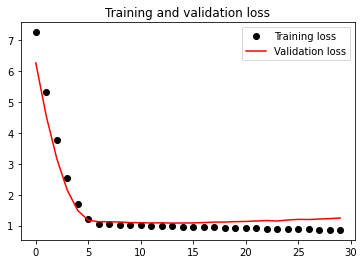

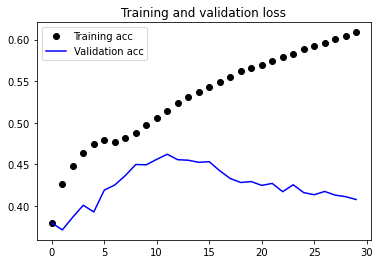

In [52]:
import matplotlib.pyplot as plt

loss = plt.figure(1)
history_loss = history.history['loss']
history_val_loss = history.history['val_loss']
epochs = range(len(history_loss))

plt.plot(epochs, history_loss, 'ko', label='Training loss')
plt.plot(epochs, history_val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

loss = plt.figure(2)
history_acc = history.history['accuracy']
history_val_acc = history.history['val_accuracy']
epochs = range(len(history_loss))

plt.plot(epochs, history_acc, 'ko', label='Training acc')
plt.plot(epochs, history_val_acc, 'b', label='Validation acc')
plt.title('Training and validation loss')
plt.legend()

plt.show()